<a href="https://colab.research.google.com/github/Modinat-A/CE888/blob/main/lab3/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier

In [30]:
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv',delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [31]:
print(df['nr.employed'].value_counts())

5228.1    16234
5099.1     8534
5191.0     7763
5195.8     3683
5076.2     1663
5017.5     1071
4991.6      773
5008.7      650
4963.6      635
5023.5      172
5176.3       10
Name: nr.employed, dtype: int64


In [ ]:
features = ['job' , 'marital' , 'education', 'default' , 'housing' , 'loan' , 'contact' , 'month' ,'day_of_week', 'poutcome' ]


## Data Preprocessing

    1. Use LabelEncoder to convert the label into numbers.
    2. Perform one-hot encoding on the categorical features using df_dummies = pd.get_dummies(df)
    4. Column "duration" must be deleted
    5. Check if there are any missing values in the dataset.     
    6. If there are, drop the rows.
    7. Plot a histogram of the label (i.e., column 'y') and calculate the imbalance in the dataset (i.e., divide the number of instances of the minority class by the total length of the dataframe).

In [ ]:
# separate your dataset into a training and a test set, with a test size of 20% and random_state=50.
# Report the results of 10-fold stratified cross-validation on the training set using a random 
# forest classifier with 100 trees and depth=3.
# Ensure you're using an appropriate metric (print sorted(sklearn.metrics.SCORERS.keys()) to see what are the valid options and choose one for cross-validation).
# Compare the cross-validation results of your classifier with that of a dummy classifier.
# Use GridSearchCV to find a better set of parameters for your random forest.
# Print the cross-validation metric (whichever you previously chose) that you obtain for the random forest for the best parameters found with GridSearchCV (on your training set)
# What are the top 3 features?
# Report the generalisation error (still using the same metric) on your test set.

In [32]:
df = df.drop(columns=['duration'])
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [33]:
# Split into training and test sets
train_set, test_set = train_test_split(df, test_size=0.2, random_state=50,stratify=df['y'])  
print(len(train_set), len(test_set))

32950 8238


In [34]:
df = train_set.copy()
print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))
# Separate features from outcomes
y_df = df['y'].copy()
y_df.columns = ['y']
X_df = df.loc[:, df.columns != 'y'].copy()

Number of rows before dropping NaNs: 32950
Number of rows after dropping NaNs: 32950


In [ ]:
X_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
38445,22,student,single,high.school,no,no,no,cellular,oct,fri,3,6,1,success,-3.4,92.431,-26.9,0.730,5017.5
17713,36,admin.,married,university.degree,no,yes,no,cellular,jul,tue,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
30309,37,admin.,married,high.school,no,yes,no,cellular,apr,thu,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1
25951,38,housemaid,married,basic.6y,unknown,no,no,cellular,nov,wed,2,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
29064,41,admin.,single,high.school,no,no,no,cellular,apr,fri,3,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11470,37,housemaid,married,high.school,no,no,yes,telephone,jun,fri,1,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
18260,43,admin.,divorced,high.school,no,no,no,cellular,jul,wed,4,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
141,56,management,married,unknown,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
19789,47,services,married,high.school,no,yes,yes,cellular,aug,fri,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1


In [35]:
class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)

In [36]:
cat_features= ['job',	'marital',	'education', 'default',	'housing','loan',	'contact',	'month','day_of_week','poutcome']

encoder = OneHotEncoderCategoricalFeatures(cat_features)
X_oho = encoder.transform(X_df)
X_oho

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
38445,22,3,6,1,-3.4,92.431,-26.9,0.730,5017.5,0,...,1,0,1,0,0,0,0,0,0,1
17713,36,1,999,0,1.4,93.918,-42.7,4.961,5228.1,1,...,0,0,0,0,0,1,0,0,1,0
30309,37,1,999,0,-1.8,93.075,-47.1,1.365,5099.1,1,...,0,0,0,0,1,0,0,0,1,0
25951,38,2,999,0,-0.1,93.200,-42.0,4.120,5195.8,0,...,0,0,0,0,0,0,1,0,1,0
29064,41,3,999,0,-1.8,93.075,-47.1,1.405,5099.1,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11470,37,1,999,0,1.4,94.465,-41.8,4.959,5228.1,0,...,0,0,1,0,0,0,0,0,1,0
18260,43,4,999,0,1.4,93.918,-42.7,4.963,5228.1,1,...,0,0,0,0,0,0,1,0,1,0
141,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
19789,47,1,999,0,1.4,93.444,-36.1,4.966,5228.1,0,...,0,0,1,0,0,0,0,0,1,0


In [37]:
# Let's also look at standardising some of the numerical features
num_features = ['age','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

# Use column transformer: numerical features will be standardised; categorical features will be transformed with OHO

# We can use a ColumnTransformer to transform only some types of columns in different ways
colTransformer = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'  # i.e., leave the rest of the columns untouched -- otherwise, they're dropped
    )

X_processed = colTransformer.fit_transform(X_df)
X_processed.shape

(32950, 62)

In [38]:
label = LabelEncoder()
df_y= label.fit_transform(y_df)

In [11]:
df_y

array([1, 0, 1, ..., 0, 0, 0])

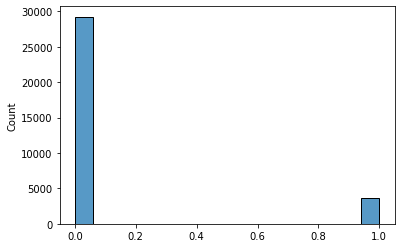

In [18]:
y = df_y
_ = sns.histplot(y, kde=False)

In [42]:
y_transformer = StandardScaler()  # we'll need this scaler for the test set later!

In [16]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_processed, df_y)
print("Dummy ACC: %.2f" % f1(df_y, dummy_clf.predict(X_processed)))

Dummy ACC: 0.10


In [43]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=50)
scores = cross_val_score(clf, X_processed, y, cv=10,scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.90 +/- 0.00


In [ ]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
# using random_state=50 , 100 estimators and a maximum depth of 8. Report the average F1 score with two numbers after the floating point (e.g., 0.56)
clf = RandomForestClassifier(n_estimators=100, max_depth=6,random_state=60)
scores = cross_val_score(clf, X_processed, y, cv=10,scoring=make_scorer(f1))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.28 +/- 0.04


In [ ]:
scores

array([0.25917927, 0.30172414, 0.23059867, 0.28695652, 0.23788546,
       0.2962963 , 0.3910387 , 0.25382932, 0.2745098 , 0.27408994])

In [ ]:
# using random_state=50 , 250 estimators and a maximum depth of 6. Report the average F1 score with two numbers after the floating point (e.g., 0.56)
clf = RandomForestClassifier(n_estimators=200, max_depth=8,random_state=50)
scores = cross_val_score(clf, X_processed, y, cv=10,scoring=make_scorer(f1))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.30 +/- 0.04


In [ ]:
# using random_state=60 , 100 estimators and a maximum depth of 12. Report the average F1 score with two numbers after the floating point (e.g., 0.56)
clf = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=50)
scores = cross_val_score(clf, X_processed, y, cv=10,scoring=make_scorer(f1))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.30 +/- 0.04


In [ ]:
# using random_state=60 , 100 estimators and a maximum depth of 12. Report the average F1 score with two numbers after the floating point (e.g., 0.56)
clf = RandomForestClassifier(n_estimators=1000, max_depth=8,random_state=60)
scores = cross_val_score(clf, X_processed, y, cv=10,scoring=make_scorer(f1))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.30 +/- 0.05


In [19]:
#Train a random forest classifier with 400 estimators and a maximum depth of 6, setting the random_state parameter to 60.
#What are the top 3 features?
clf = RandomForestClassifier(n_estimators=100, max_depth=12)
scores = cross_val_score(clf, X_processed, y, cv=10,scoring=make_scorer(f1))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))


ACC: 0.35 +/- 0.04


[ 5  4 60  0 58  1  3  2 59 61 57 56 39 49 46 40 47 52 35 33 28 51 54 53
 19 20 36  6 55 25 41 11 38  7 27 15 14 45 31 30 50 24 18 22 29 10 13 42
 23 12 16 44 48  9 37 34 17 43  8 21 26 32]
Feature ranking:
1. nr.employed (0.142672)
2. euribor3m (0.129056)
3. campaign (0.091189)
4. age (0.062948)
5. success (0.061454)
6. emp.var.rate (0.056543)
7. cons.conf.idx (0.054685)
8. cons.price.idx (0.040529)
9. age (0.025435)
10. pdays (0.018957)
11. nonexistent (0.015921)
12. failure (0.014703)
13. cellular (0.013412)
14. oct (0.013255)
15. mar (0.012823)
16. telephone (0.011079)
17. may (0.010541)
18. mon (0.010268)
19. yes (0.008591)
20. no (0.008460)
21. university.degree (0.008403)
22. fri (0.007915)
23. tue (0.007725)
24. thu (0.007670)
25. married (0.007385)
26. single (0.007303)
27. no (0.007283)
28. admin. (0.007248)
29. wed (0.006902)
30. high.school (0.006671)
31. apr (0.006625)
32. retired (0.006572)
33. yes (0.006189)
34. blue-collar (0.006038)
35. professional.course (0.006020)
3

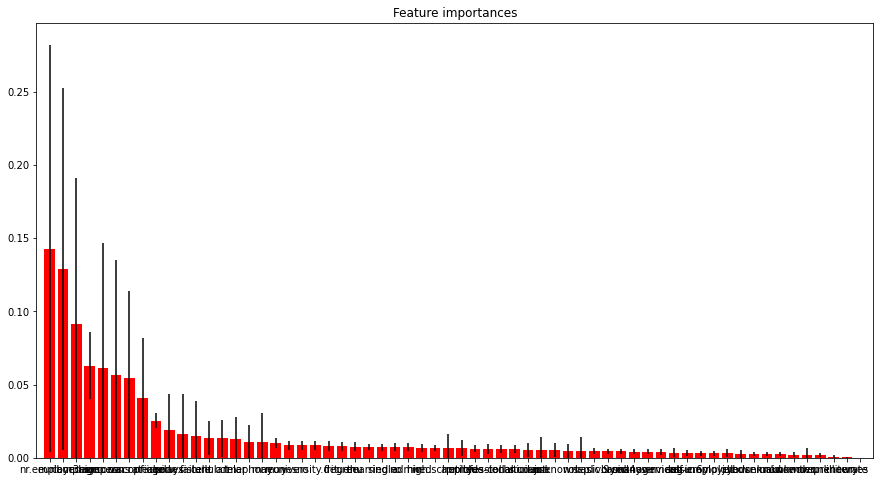

In [23]:
clf.fit(X_processed, y)

# Let's see the feature importances for our classifier
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Let's get the attibute names:
extra_attribs = ['age',	'campaign','pdays']  # the ones we didn't modify in the transformer
cat_encoder = colTransformer.named_transformers_['cat']
cat_oho_attributes = oho_categories = [item for sublist in cat_encoder.categories_ for item in sublist]
feat_names = num_features + cat_oho_attributes + extra_attribs

X = X_processed
# Print the feature ranking
print("Feature ranking:")
for f in range(X_processed.shape[1]):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feat_names)[indices])
plt.xlim([-1, X.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

In [48]:
import pickle as pkl

outp = open('model1.pkl', 'wb')
pkl.dump(clf, outp, -1)  # where clf is your classifier
outp.close()

In [49]:
df = test_set.copy()
# Separate features from outcomes
y_df = df['y'].copy()
y_df.columns = ['y']
X_df = df.loc[:, df.columns != 'y'].copy()

In [50]:
cat_features= ['job',	'marital',	'education', 'default',	'housing','loan',	'contact',	'month','day_of_week','poutcome']
num_features = ['age','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

# Use column transformer: numerical features will be standardised; categorical features will be transformed with OHO

# We can use a ColumnTransformer to transform only some types of columns in different ways
colTransformer = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'  # i.e., leave the rest of the columns untouched -- otherwise, they're dropped
    )

X_processed = colTransformer.fit_transform(X_df)
X_processed.shape
label = LabelEncoder()
df_y= label.fit_transform(y_df)

In [51]:
y_df= pd.DataFrame(df_y,columns=['y'])
x_df= pd.DataFrame(X_processed)

In [52]:
testset = pd.concat([x_df , y_df], axis=1, join="inner")
testset.to_csv('test.csv')

In [54]:
from sklearn.metrics import f1_score

In [55]:
import os
f = open('model1.pkl', 'rb')
clf = pkl.load(f)
testset = pd.read_csv('test.csv')

x, y = testset.drop(labels=['y'], axis=1, inplace=False), testset['y']
y_pred = clf.predict(x)
f1 = f1_score(y, y_pred)
print("F1-score on test set:", f1)

if f1 > 0.9:
  print("Success!")

F1-score on test set: 0.1360153256704981


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
